In [1]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import wilcoxon
from scipy.spatial.distance import mahalanobis
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Generate Synthetic Data

Since we don't have access to the actual dataset used in the journal, we replicate the variables that were mentioned.

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of patients
n_patients = 400

# Generate enrollment time in months
enrollment_time = np.random.randint(0, 12, size=n_patients)

# Define possible time points for treatment (e.g., after 3 months, 6 months, etc.)
time_points = np.arange(3, 25, 3)  # Possible treatment times from 3 months to 24 months

# Baseline symptoms (Pain, Urgency, Frequency)
# Pain and Urgency: 0-9, Frequency: 0-20
baseline_symptoms = np.column_stack([
    np.random.randint(0, 10, size=n_patients),  # Pain (0-9)
    np.random.randint(0, 10, size=n_patients),  # Urgency (0-9)
    np.random.randint(0, 21, size=n_patients)   # Frequency (0-20)
])

# Generate the "treated" and "treatment time"
treated_indicator = np.zeros(n_patients)  # Initialize all as untreated
treatment_time = np.full(n_patients, np.inf)  # Initialize with np.inf (for untreated patients)

# Simulate simple treatment decision: randomized treatment probability
for i in range(n_patients):
    treat_prob = np.random.uniform(0.1, 0.5)
    # Flip a coin based on the treatment probability (binomial distribution)
    treated = np.random.binomial(1, treat_prob)
    treated_indicator[i] = treated
    
    # If treated, assign a treatment time randomly from the available time points (excluding the first and last)
    if treated:
        treatment_time[i] = np.random.choice(time_points[1:-1])

# Symptoms post-treatment (fluctuate slightly from baseline)
treatment_symptoms = baseline_symptoms + np.random.randint(-2, 2, size=(n_patients, 3))

# Enforce bounds for Pain and Urgency (0-9), Frequency (0-20)
treatment_symptoms[:, 0] = np.clip(treatment_symptoms[:, 0], 0, 9)  # Pain
treatment_symptoms[:, 1] = np.clip(treatment_symptoms[:, 1], 0, 9)  # Urgency
treatment_symptoms[:, 2] = np.clip(treatment_symptoms[:, 2], 0, 20) # Frequency

# Follow-up symptoms
symptoms_3m = treatment_symptoms + np.random.randint(-2, 2, size=(n_patients, 3))
symptoms_3m[:, 0] = np.clip(symptoms_3m[:, 0], 0, 9)  # Pain
symptoms_3m[:, 1] = np.clip(symptoms_3m[:, 1], 0, 9)  # Urgency
symptoms_3m[:, 2] = np.clip(symptoms_3m[:, 2], 0, 20) # Frequency

symptoms_6m = symptoms_3m + np.random.randint(-2, 2, size=(n_patients, 3))
symptoms_6m[:, 0] = np.clip(symptoms_6m[:, 0], 0, 9)  # Pain
symptoms_6m[:, 1] = np.clip(symptoms_6m[:, 1], 0, 9)  # Urgency
symptoms_6m[:, 2] = np.clip(symptoms_6m[:, 2], 0, 20) # Frequency

# For the 3-month frequency:
improvement_3m = np.where(treated_indicator == 1, np.random.binomial(1, 0.6, size=n_patients), 0)
# Subtract the additional improvement and re-clip to maintain bounds
symptoms_3m[:, 2] = np.clip(symptoms_3m[:, 2] - improvement_3m, 0, 20)

# For the 6-month frequency:
improvement_6m = np.where(treated_indicator == 1, np.random.binomial(1, 0.6, size=n_patients), 0)
symptoms_6m[:, 2] = np.clip(symptoms_6m[:, 2] - improvement_6m, 0, 20)

# Gender (0 = Female, 1 = Male)
gender = np.random.choice([0, 1], size=n_patients)

# Create DataFrame
df = pd.DataFrame({
    'Patient_ID': np.arange(1, n_patients + 1),
    'Enrollment_Time': enrollment_time,
    'Treatment_Time': treatment_time,
    'Treated': treated_indicator,
    'base_pain': baseline_symptoms[:, 0],
    'base_urgency': baseline_symptoms[:, 1],
    'base_frequency': baseline_symptoms[:, 2],
    'treatment_pain': treatment_symptoms[:, 0],
    'treatment_urgency': treatment_symptoms[:, 1],
    'treatment_frequency': treatment_symptoms[:, 2],
    'Pain_3M': symptoms_3m[:, 0],
    'Urgency_3M': symptoms_3m[:, 1],
    'Frequency_3M': symptoms_3m[:, 2],
    'Pain_6M': symptoms_6m[:, 0],
    'Urgency_6M': symptoms_6m[:, 1],
    'Frequency_6M': symptoms_6m[:, 2],
    'Gender': gender
})

df.head(20)


,Patient_ID,Enrollment_Time,Treatment_Time,Treated,base_pain,base_urgency,base_frequency,treatment_pain,treatment_urgency,treatment_frequency,Pain_3M,Urgency_3M,Frequency_3M,Pain_6M,Urgency_6M,Frequency_6M,Gender
0,1,6,15.0,1.0,0,1,13,0,2,14,0,0,12,0,0,13,0
1,2,3,inf,0.0,8,5,13,6,4,14,7,3,13,7,3,11,0
2,3,10,inf,0.0,5,4,10,5,3,10,3,4,9,2,3,7,1
3,4,7,inf,0.0,6,1,15,7,1,13,6,1,11,7,0,11,1
4,5,4,inf,0.0,9,2,3,9,1,3,9,1,2,9,2,1,1
5,6,6,inf,0.0,6,8,19,6,6,19,4,7,18,5,8,17,1
6,7,9,12.0,1.0,9,6,4,9,7,5,9,8,2,8,9,2,0
7,8,2,inf,0.0,2,6,20,1,7,20,1,5,20,0,6,20,1
8,9,6,15.0,1.0,1,5,13,2,6,11,1,7,9,1,8,10,1
9,10,10,15.0,1.0,8,7,15,9,5,13,8,3,13,6,1,12,1


In [3]:
df["Treated"].value_counts()

Treated
0.0    271
1.0    129
Name: count, dtype: int64

In [4]:
df.shape

(400, 17)

In [5]:
# Extract treated and control groups
treated = df[df["Treated"] == 1].copy()
control = df[df["Treated"] == 0].copy()

In [6]:
# Standardize covariates for Mahalanobis distance calculation
covariates = ["base_pain", "base_urgency", "base_frequency",
              "treatment_pain", "treatment_urgency", "treatment_frequency"]

scaler = StandardScaler()
treated_scaled = scaler.fit_transform(treated[covariates])
control_scaled = scaler.transform(control[covariates])

# Compute inverse covariance matrix for Mahalanobis distance
cov_matrix = np.cov(treated_scaled.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Optimal Pair Matching

In [7]:
# Perform optimal matching with a limit of 100 pairs
matches = []
used_control_indices = set()
max_pairs = 100  # Limit the number of matched pairs to 100

for t_idx, t_row in treated.iterrows():
    if len(matches) >= max_pairs:
        break  # Stop once 100 pairs are formed

    # Find eligible control patients (who were enrolled before treatment)
    eligible_controls = control[control["Enrollment_Time"] <= t_row["Treatment_Time"]].copy()
    
    # Remove already matched controls
    eligible_controls = eligible_controls[~eligible_controls.index.isin(used_control_indices)]
    
    if eligible_controls.empty:
        continue  # No eligible controls for this treated patient
    
    # Compute Mahalanobis distances
    distances = []
    t_vector = scaler.transform(pd.DataFrame([t_row[covariates]], columns=covariates))[0]

    for c_idx, c_row in eligible_controls.iterrows():
        c_vector = scaler.transform(pd.DataFrame([c_row[covariates]], columns=covariates))[0]
        dist = mahalanobis(t_vector, c_vector, inv_cov_matrix)
        distances.append((dist, c_idx))
    
    # Select the closest control match
    distances.sort()
    best_match = distances[0][1]  # Get the index of the closest match
    
    matches.append((t_idx, best_match))
    used_control_indices.add(best_match)  # Mark this control as used

    if len(matches) >= max_pairs:
        break  # Ensure we stop at 100 pairs

# Convert matches to DataFrame
matched_pairs = pd.DataFrame(matches, columns=["Treated_Patient", "Control_Patient"])

#Print matched pairs
print(matched_pairs.head(15))
# Display total number of matched pairs
total_matched_pairs = len(matched_pairs)
print(f"Total number of matched pairs: {total_matched_pairs}")


    Treated_Patient  Control_Patient
0                 0              376
1                 6               11
2                 8              158
3                 9              168
4                12               91
5                14              232
6                17              373
7                20               64
8                21              389
9                23               82
10               29              144
11               32              194
12               34              304
13               36              262
14               37              113
Total number of matched pairs: 100


# Mahalanobis Distance

In [8]:
# Function to compute average Mahalanobis distance
def compute_mahalanobis_dist(group1, group2, covariates):
    X1 = group1[covariates].values
    X2 = group2[covariates].values

    # Standardize data
    scaler = StandardScaler()
    X1_scaled = scaler.fit_transform(X1)
    X2_scaled = scaler.transform(X2)

    # Compute covariance matrix and inverse
    cov_matrix = np.cov(np.vstack((X1_scaled, X2_scaled)).T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Compute Mahalanobis distance for each treated-control pair
    distances = []
    for i in range(len(X1_scaled)):
        dist = mahalanobis(X1_scaled[i], X2_scaled[i % len(X2_scaled)], inv_cov_matrix)
        distances.append(dist)
    
    return np.mean(distances)  # Return average Mahalanobis distance

# Comparison of Mahalonobis Distance Before & After Matching

In [9]:
# Extract treated and control groups
treated = df[df["Treated"] == 1].copy()
control = df[df["Treated"] == 0].copy()

# Compute Mahalanobis distance before matching
mahal_before = compute_mahalanobis_dist(treated, control, covariates)

# Extract matched treated and control patients
treated_matched = df.loc[matched_pairs["Treated_Patient"]]
control_matched = df.loc[matched_pairs["Control_Patient"]]

# Compute Mahalanobis distance after matching
mahal_after = compute_mahalanobis_dist(treated_matched, control_matched, covariates)

# Print Results
print(f"Mahalanobis Distance Before Matching: {mahal_before:.3f}")
print(f"Mahalanobis Distance After Matching: {mahal_after:.3f}")


Mahalanobis Distance Before Matching: 3.418
Mahalanobis Distance After Matching: 1.155


In [10]:
# Prepare Data for Graphical Representation
def extract_measurements(pair_list, variable, timepoint):
    vals = []
    for i, j in pair_list:
        if timepoint in ['change_3M', 'change_6M']:
            # Compute pre-treatment averages
            treated_pretreat_avg = (df.loc[i, f'base_{variable}'] + df.loc[i, f'treatment_{variable}']) / 2.0
            control_pretreat_avg = (df.loc[j, f'base_{variable}'] + df.loc[j, f'treatment_{variable}']) / 2.0

            # Get post-treatment values using correct capitalization
            post_treatment_tp = f"{variable.capitalize()}_3M" if timepoint == "change_3M" else f"{variable.capitalize()}_6M"
            
            # Verify if the column exists
            if post_treatment_tp not in df.columns:
                raise KeyError(f"Column '{post_treatment_tp}' not found in DataFrame. Available columns: {df.columns}")

            treated_post = df.loc[i, post_treatment_tp]
            control_post = df.loc[j, post_treatment_tp]

            # Compute differences from pre-treatment average
            treated_diff = treated_post - treated_pretreat_avg
            control_diff = control_post - control_pretreat_avg

            vals.append((treated_diff, control_diff))
        else:
            # Standard case for baseline, treatment, 3M, and 6M values
            column_mapping = {
                'baseline': f'base_{variable}',
                'treatment': f'treatment_{variable}',
                '3M': f'{variable.capitalize()}_3M',
                '6M': f'{variable.capitalize()}_6M'
            }
            column_name = column_mapping.get(timepoint)

            if column_name not in df.columns:
                raise KeyError(f"Column '{column_name}' not found in DataFrame. Available columns: {df.columns}")

            vals.append((df.loc[i, column_name], df.loc[j, column_name]))
    
    return np.array(vals)

In [11]:
# Convert DataFrame to list of tuples
pair_list = list(matched_pairs.itertuples(index=False, name=None))

# Define the variables and time points for plotting
variables = ['pain', 'urgency', 'frequency']
timepoints = ['baseline', 'treatment', '3M', '6M', 'change_3M', 'change_6M']
timepoint_labels = {
    'baseline': 'Baseline',
    'treatment': 'At Treatment',
    '3M': '3 Months after Treatment',
    '6M': '6 Months after Treatment',
    'change_3M': 'Difference (3 mos posttreatment)',
    'change_6M': 'Difference (6 mos posttreatment)'
}

In [12]:
# Build a long-form DataFrame
plot_data = []
for var in variables:
    for tp in timepoints:
        measurements = extract_measurements(pair_list, var, tp)
        if tp in ['change_3M', 'change_6M']:
            # Store treated and control differences
            for idx in range(measurements.shape[0]):
                plot_data.append({
                    'Variable': var.capitalize(),
                    'TimePoint': timepoint_labels[tp],
                    'Group': 'Treated',
                    'Value': measurements[idx, 0]  # Treated difference
                })
                plot_data.append({
                    'Variable': var.capitalize(),
                    'TimePoint': timepoint_labels[tp],
                    'Group': 'Never/Later Treated',
                    'Value': measurements[idx, 1]  # Control difference
                })
        else:
            # Store standard Treated and Control values
            for idx in range(measurements.shape[0]):
                plot_data.append({
                    'Variable': var.capitalize(),
                    'TimePoint': timepoint_labels[tp],
                    'Group': 'Treated',
                    'Value': measurements[idx, 0]
                })
                plot_data.append({
                    'Variable': var.capitalize(),
                    'TimePoint': timepoint_labels[tp],
                    'Group': 'Never/Later Treated',
                    'Value': measurements[idx, 1]
                })

plot_df = pd.DataFrame(plot_data)

In [13]:
# Function to calculate Standardized Mean Difference (SMD)
def compute_smd(treated_group, control_group, covariates):
    smd_results = {}
    for cov in covariates:
        mean_treated = treated_group[cov].mean()
        mean_control = control_group[cov].mean()
        pooled_std = np.sqrt((treated_group[cov].std()**2 + control_group[cov].std()**2) / 2)
        smd = np.abs(mean_treated - mean_control) / pooled_std
        smd_results[cov] = smd
    return smd_results

In [14]:
# Extract matched treated and control patients
matched_treated = df.loc[matched_pairs["Treated_Patient"]]
matched_control = df.loc[matched_pairs["Control_Patient"]]

# Compute Standardized Mean Differences (SMD)
smd_values = compute_smd(matched_treated, matched_control, covariates)

# Display SMD results
print("\nStandardized Mean Differences (SMD) for Matched Data:")
for cov, smd in smd_values.items():
    print(f"{cov}: {smd:.3f}")

# Check p-values using t-tests
print("\nT-test results (p-values) for matched groups:")
for cov in covariates:
    _, p_value = ttest_ind(matched_treated[cov], matched_control[cov], equal_var=False)
    print(f"{cov}: p-value = {p_value:.3f}")


Standardized Mean Differences (SMD) for Matched Data:
base_pain: 0.109
base_urgency: 0.007
base_frequency: 0.012
treatment_pain: 0.081
treatment_urgency: 0.011
treatment_frequency: 0.010

T-test results (p-values) for matched groups:
base_pain: p-value = 0.443
base_urgency: p-value = 0.959
base_frequency: p-value = 0.933
treatment_pain: p-value = 0.569
treatment_urgency: p-value = 0.938
treatment_frequency: p-value = 0.943


# Matching Quality

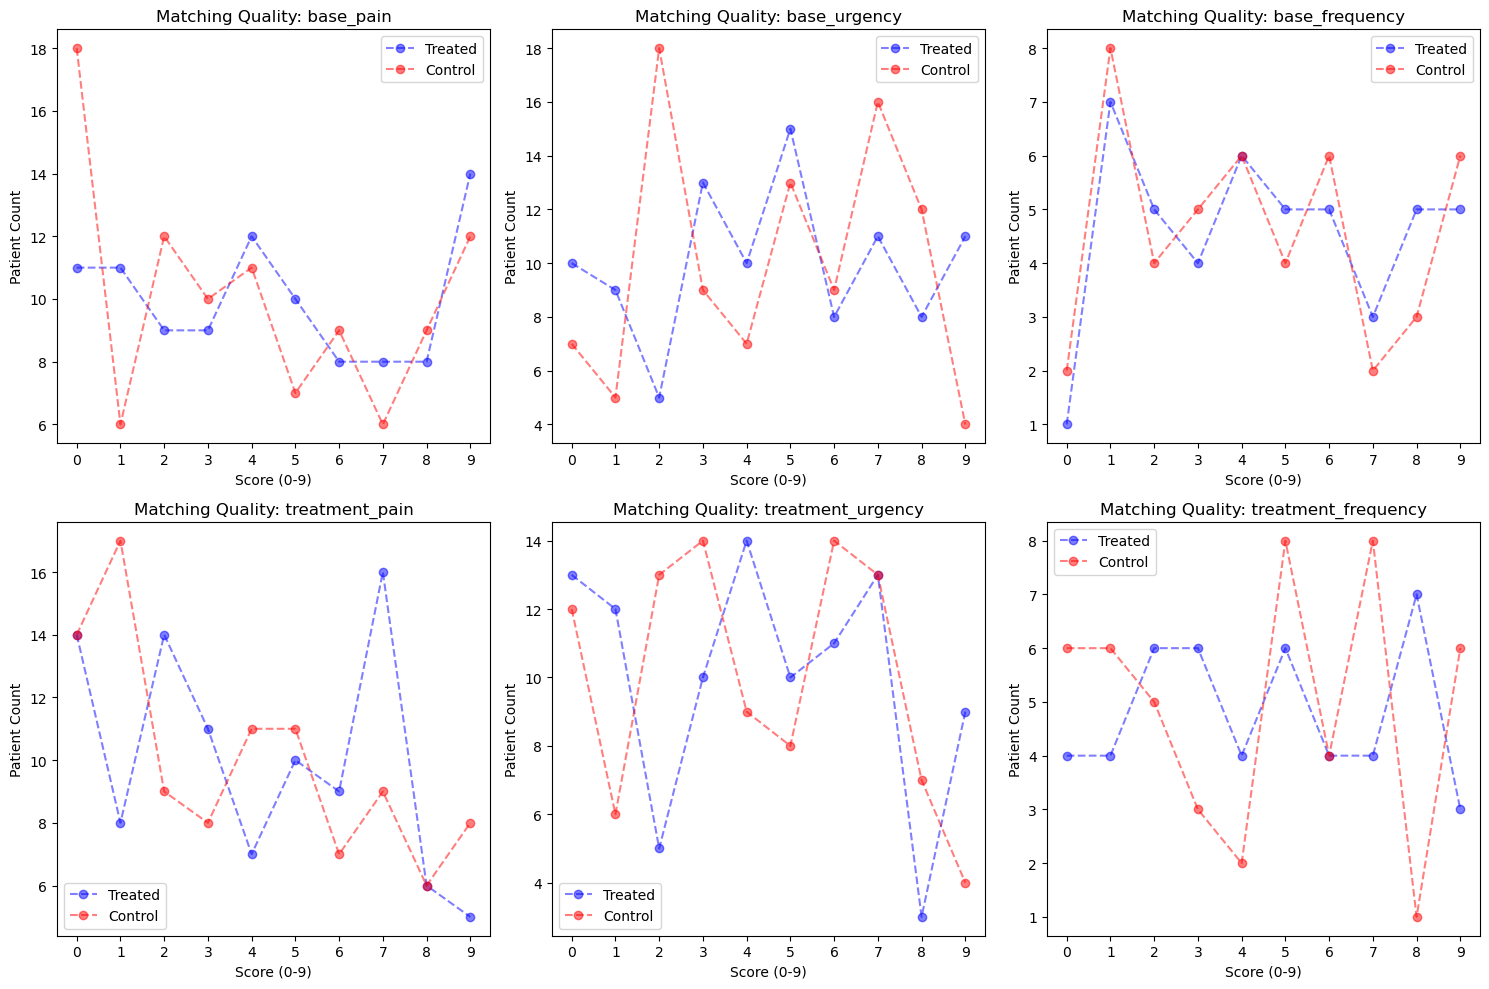

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, cov in enumerate(covariates):
    # Get distributions
    treated_before = df[df["Treated"] == 1][cov].value_counts().sort_index()
    control_before = df[df["Treated"] == 0][cov].value_counts().sort_index()
    treated_after = matched_treated[cov].value_counts().sort_index()
    control_after = matched_control[cov].value_counts().sort_index()

    # Reindex for consistency
    index_range = range(10)
    treated_before = treated_before.reindex(index_range, fill_value=0)
    control_before = control_before.reindex(index_range, fill_value=0)
    treated_after = treated_after.reindex(index_range, fill_value=0)
    control_after = control_after.reindex(index_range, fill_value=0)

    # Plot as line plots
    axes[i].plot(index_range, treated_after, marker="o", linestyle="--", color="blue", alpha=0.5, label="Treated")
    axes[i].plot(index_range, control_after, marker="o", linestyle="--", color="red", alpha=0.5, label="Control")

    # Formatting
    axes[i].set_title(f"Matching Quality: {cov}")
    axes[i].set_xlabel("Score (0-9)")
    axes[i].set_ylabel("Patient Count")
    axes[i].set_xticks(index_range)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Graph Visualization

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_graph(variable):
    # Validate the input variable
    variable_lower = variable.lower()
    if variable_lower not in ['pain', 'urgency', 'frequency']:
        raise ValueError("Variable must be 'pain', 'urgency', or 'frequency'.")
    
    variable_cap = variable_lower.capitalize()
    data = plot_df[plot_df['Variable'] == variable_cap]
    
    # Create a 3x2 figure (6 subplots total)
    fig, axes = plt.subplots(3, 2, figsize=(4*3, 5*2), sharey=False)
    axes = axes.flatten()
    
    # First 4 timepoints
    timepoints_main = data['TimePoint'].unique()[:4]
    for j, tp in enumerate(timepoints_main):
        ax = axes[j]
        subdata = data[data['TimePoint'] == tp]
        sns.boxplot(x='Group', y='Value', data=subdata, ax=ax, width=0.3)
        ax.set_title(f"{tp}")
        ax.set_xlabel("")
        
        # Set ylabel based on the variable
        if variable_lower == 'pain':
            ax.set_ylabel("Pain Score")
        elif variable_lower == 'urgency':
            ax.set_ylabel("Urgency Score")
        else:
            ax.set_ylabel("Frequency Score")
        
        # Adjust ylim for frequency
        if variable_lower == 'frequency':
            ax.set_ylim(-0.5, 21)
        else:
            ax.set_ylim(-0.5, 9.5)
    
    # Last 2 timepoints (contrast differences)
    timepoints_diff = data['TimePoint'].unique()[-2:]
    for j, tp in enumerate(timepoints_diff, start=4):
        ax = axes[j]
        subdata = data[data['TimePoint'] == tp]
        sns.boxplot(x='Group', y='Value', data=subdata, ax=ax, width=0.3)
        ax.set_title(f"{tp}")
        ax.set_xlabel("")
        ax.set_ylabel("Difference from Pre-Treatment")
        ax.set_ylim(-6.5, 3.5)  # Adjust based on your data
    
    # Hide unused subplots (if any)
    for j in range(len(timepoints_main) + len(timepoints_diff), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

## Pain Graph

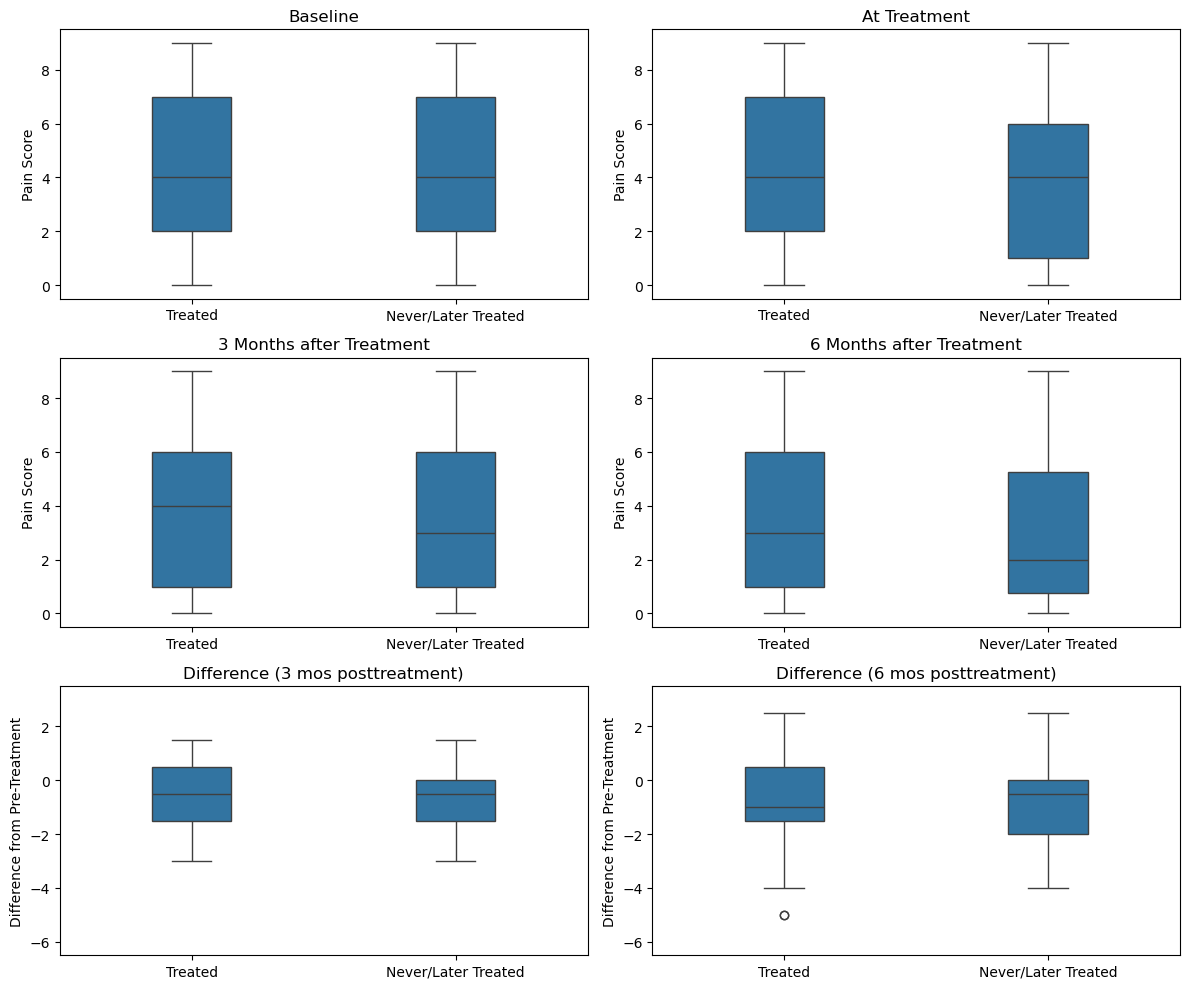

In [17]:
display_graph('pain')

## Urgency Graph

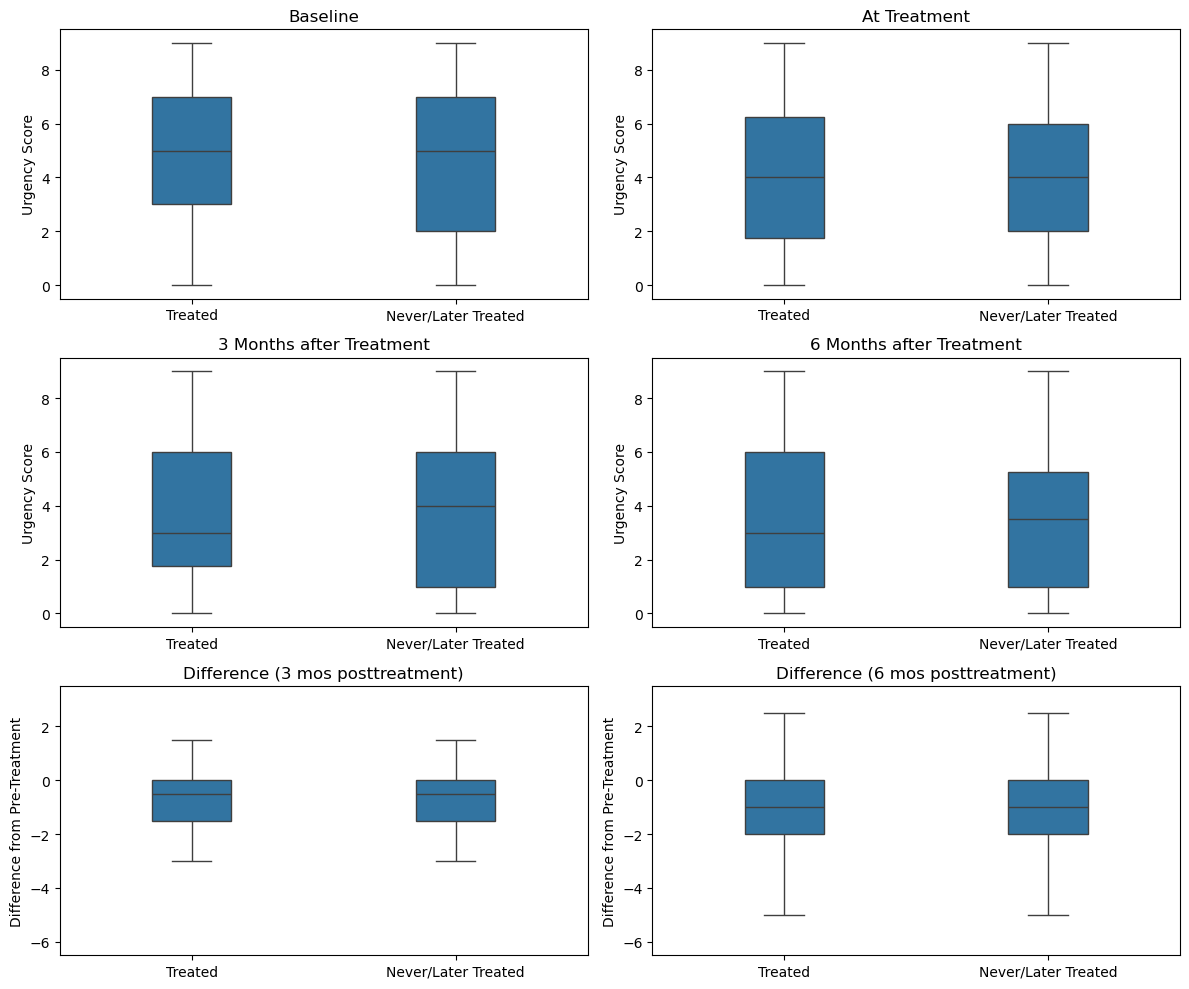

In [18]:
display_graph('urgency')

## Frequency Graph

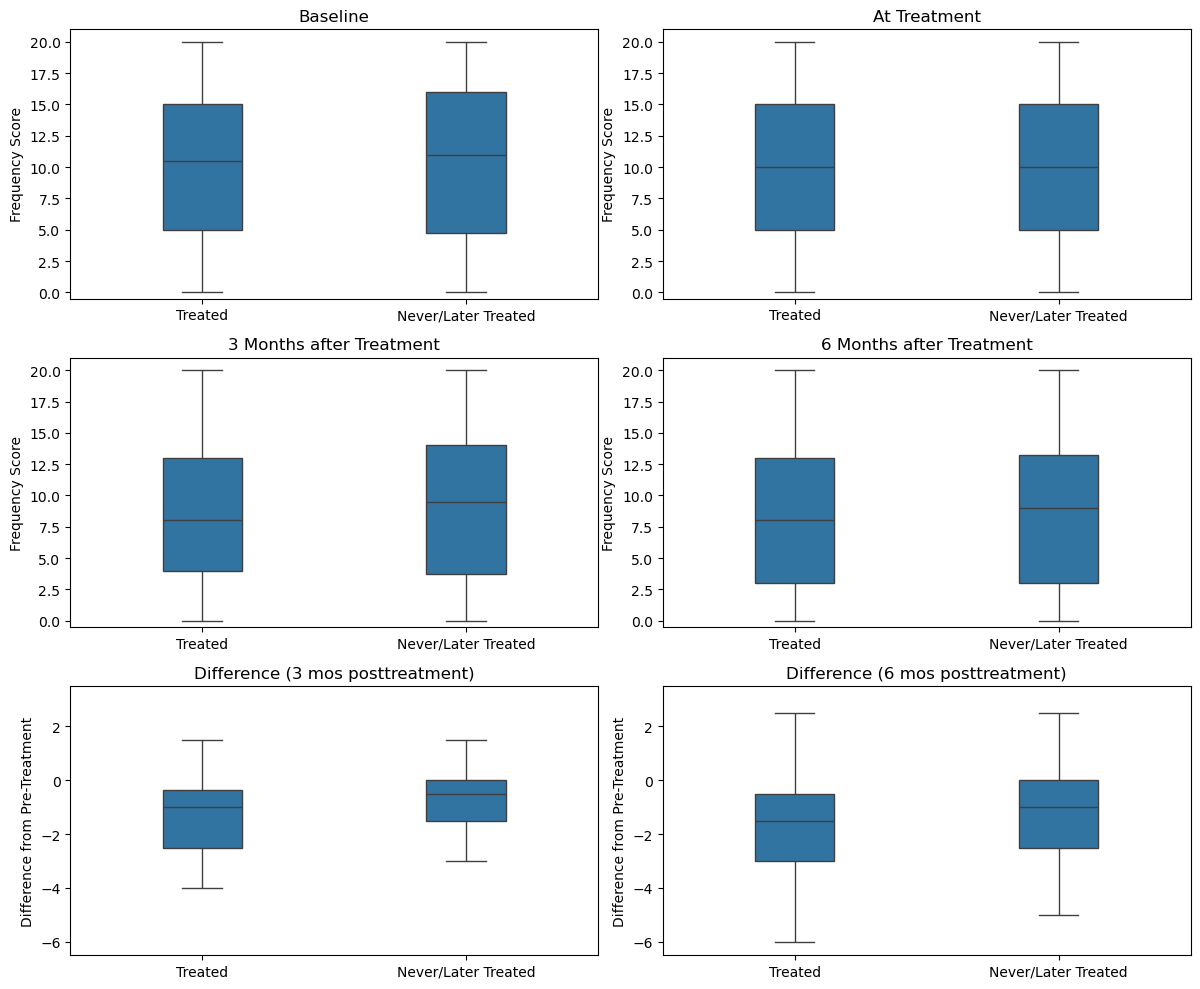

In [19]:
display_graph('frequency')